In [2]:
from classix_t import CLASSIX_T
from sklearn.metrics import adjusted_rand_score as ari
import time
import numpy as np
import random
from copy import deepcopy
from sklearn.cluster import DBSCAN, HDBSCAN, OPTICS, MeanShift

In [3]:
def generate_data(num_clusters, pops, d, n, flip_prob=0.1, seed=None):
    """
    Generate data for the CLASSIX_T dataset

        Parameters: \n
        num_clusters (int)  : number of clusters \n
        pops (list)         : the popcount of the different cluster centers. len(pops) must be equal to num_clusters \n
        d (int)             : dimension of the data \n
        n (int)             : number of total samples per cluster \n
        seed (int)          : seed for the random number generator \n


    """
    assert len(pops)>1, "You must provide at least 2 cluster mean populations in order to generate meaningful data"
    if len(pops) != num_clusters:
        try:
            print("The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user")
            pops = np.linspace(min(pops), max(pops), num_clusters)
        except:
            raise ValueError("The number of cluster centers must be equal to the number of cluster populations")
    
    size_flag = [pops[x]<d for x in range(len(pops))]
    
    assert all(size_flag), "The number of dimensions must be greater than the pop counts of the clusters"
    
    clustc = []
    data = []
    if seed != None:
        np.random.seed(seed)
        random.seed(seed)

    labels = []

    for i in range(num_clusters):
        pop = pops[i]
        p1 = pop/d
        clustc.append(np.random.choice([0, 1], size=d, p=[1-p1, p1]))
        data.append(clustc[-1])
        labels.append(i)
        for j in range(n-1):
            labels.append(i)
            # Instead of flipping exactly pop*flip_prob bits, we flip each bit with a probability of flip_prob.
            flip_indices = np.random.choice([0, 1], size = d, p = [1-flip_prob*p1, flip_prob*p1])
            new_sample = np.logical_xor(clustc[-1], flip_indices).astype(np.int32)
            data.append(new_sample)
    return np.array(data).astype(np.int32), np.array(labels).astype(np.int32)

Experiment 1: Dependence on number of data points

We generate data keeping the dimension constant at d=1000. The number of clusters is constant at 10. The number of points in each cluster is increased in steps of 1000 from 1000 to 100000. We observe and note the runtime of CLASSIX and compare it with scikit-learn DBSCAN with 'jaccard' metric. In the first experiment, we use clusters that were fairly well separated in terms of the pop-count of starting vectors.

In [4]:
data, labels = generate_data(num_clusters=10, pops=[100, 400], d=1000, n=1000, flip_prob=0.3, seed=0)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

tanimoto_radius = 0.4
minPts = 40
mergeScale = 1/np.sqrt(tanimoto_radius)


start = time.time()
db = DBSCAN(eps=0.4, min_samples=5, metric='jaccard' ).fit(data)
end = time.time()
print("DBSCAN took", end-start, "seconds")
ari_score = ari(labels, db.labels_)
print("ARI score for DBSCAN:", ari_score)

# start = time.time()
# db = HDBSCAN( metric='jaccard' ).fit(data)
# end = time.time()
# print("HDBSCAN took", end-start, "seconds")
# ari_score = ari(labels, db.labels_)
# print("ARI score for HDBSCAN:", ari_score)

# start = time.time()
# db = OPTICS(metric='jaccard' ).fit(data)
# end = time.time()
# print("OPTICS took", end-start, "seconds")
# ari_score = ari(labels, db.labels_)
# print("ARI score for OPTICS:", ari_score)

clx_t = CLASSIX_T(radius=tanimoto_radius, minPts=minPts, mergeScale=mergeScale)
start = time.time()
clx_t.fit(data)
end = time.time()
print("CLASSIX_T took", end-start, "seconds")
ari_score = ari(labels, clx_t.labels)
print("ARI score for CLASSIX_T:", ari_score)

The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 46.21526122093201 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 104794.20it/s]


time for ips: 0.073333740234375
time for search: 0.004550457000732422
time for conversion: 0.0032219886779785156
time for loop: 0.011050224304199219
nr_dist: 446841


100%|██████████| 312/312 [00:00<00:00, 15988.26it/s]

  merging time: 0.0256500244140625
 minPts Merging
  minPts merging time: 0.00011324882507324219
Total time: 0.2852060794830322
CLASSIX_T took 0.2861292362213135 seconds
ARI score for CLASSIX_T: 1.0


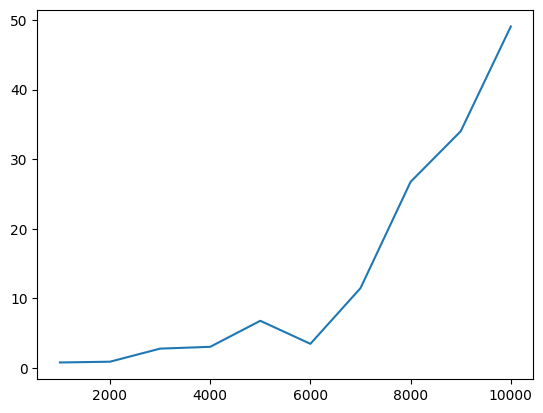

In [ ]:
time_dbscan = [50.88285303115845, 401.77172899246216, ]
ari_dbscan = [1.0, 1.0]
time_hdbscan = [87.05716824531555, 344.29443979263306, ]
ari_hdbscan = [1.0, 1.0]
# time_optics = []
time_classix_t = [0.813103199005127, 0.9244258403778076, 2.8004488945007324, 3.061615228652954, 6.7984819412231445, 3.4897470474243164, 11.485980987548828, 26.750416040420532, 34.008634090423584, 49.05707311630249]
npoints = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
ari_classix_t = [1.0, 1.0]
from matplotlib import pyplot as plt
plt.plot(npoints, time_classix_t, label="CLASSIX_T")
plt.xlabel("Number of points per cluster")
plt.ylabel("Time taken (in seconds)")

In [ ]:
start = time.time()
db = OPTICS(metric='jaccard').fit(data)
end = time.time()
print("OPTICS took", end-start, "seconds")
ari_score = ari(labels, db.labels_)
print("ARI score for OPTICS:", ari_score)

/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/cluster/_optics.py:332: DataConversionWarning: Data will be converted to boolean for metric jaccard, to avoid this warning, you may convert the data prior to calling fit.
  warnings.warn(msg, DataConversionWarning)


OPTICS took 380.70911478996277 seconds
ARI score for OPTICS: 1.0


TypeError: BisectingKMeans.__init__() got an unexpected keyword argument 'metric'

In [34]:
import rdkit

In [ ]:
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
print(DataStructs.__doc__)

Module containing an assortment of functionality for basic data structures.

At the moment the data structures defined are:
  Bit Vector classes (for storing signatures, fingerprints and the like:
    - ExplicitBitVect: class for relatively small (10s of thousands of bits) or
                       dense bit vectors.
    - SparseBitVect:   class for large, sparse bit vectors
  DiscreteValueVect:   class for storing vectors of integers
  SparseIntVect:       class for storing sparse vectors of integers



Experiment 2: Dependence on separability of data clusters by pop count

We generate data keeping the dimension constant at d=1000. The number of clusters is constant at 10, with each cluster containing 1000 points. We vary the range of seed-vector pop-count, which would affect the efficiency of the sorting and termination criteria of data. the pop-count of the seed vector with the smallest 1-norm is kept fixed at 50, the others are generated so that each seed vector has \alpha more 1s than the previous one, with the last vector containing 9\times\alpha + 50 1s. We observe and note the runtime of CLASSIX for these scenarios. We expect a lower runtime for the data in which seed vectors are more well separated by the pop-count.

In [14]:
clx_time = []
ari_clxt = []
ari_dbscan = []
ari_optics = []
db_time = []
optics_time = []
for i in range(10):
    data, labels = generate_data(10, [50, 50+50*i], 1000, 2500, 0.3, 0)
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    tanimoto_radius = 0.3
    minPts = 5
    mergeScale = 1/np.sqrt(tanimoto_radius)

    clx_t = CLASSIX_T(radius=tanimoto_radius, minPts=minPts, mergeScale=mergeScale)
    start = time.time()
    clx_t.fit(data)
    end = time.time()
    print("CLASSIX_T took", end-start, "seconds")
    clx_time.append(end-start)
    ari_clxt.append(ari(labels, clx_t.labels))
    
    # optics = OPTICS(metric='jaccard')
    # start = time.time()
    # optics.fit(data)
    # end = time.time()
    # print("OPTICS took", end-start, "seconds")
    # optics_time.append(end-start)
    # ari_optics.append(ari(labels, optics.labels_))
    # print("ARI score for OPTICS:", ari_score)

    db = DBSCAN(eps=0.4, min_samples=5, metric='jaccard' )
    start = time.time()
    db.fit(data)
    end = time.time()
    print("DBSCAN took", end-start, "seconds")
    db_time.append(end-start)
    ari_dbscan.append(ari(labels, db.labels_))
    # print("ARI score for DBSCAN:", ari_score)

The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 25000/25000 [00:00<00:00, 32142.22it/s]


time for ips: 0.6078963279724121
time for search: 0.020351886749267578
time for conversion: 0.055292606353759766
time for loop: 0.0784599781036377
nr_dist: 22592467


100%|██████████| 1711/1711 [00:00<00:00, 18730.34it/s]
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


  merging time: 0.10054206848144531
 minPts Merging
  minPts merging time: 0.0005230903625488281
Total time: 1.010159969329834
CLASSIX_T took 1.011958122253418 seconds


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 575.2871539592743 seconds
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 25000/25000 [00:00<00:00, 51404.89it/s]


time for ips: 0.42318058013916016
time for search: 0.009435415267944336
time for conversion: 0.013215065002441406
time for loop: 0.03265190124511719
nr_dist: 10290220


100%|██████████| 1139/1139 [00:00<00:00, 19519.47it/s]
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


  merging time: 0.06521415710449219
 minPts Merging
  minPts merging time: 0.0003781318664550781
Total time: 0.7061567306518555
CLASSIX_T took 0.7075471878051758 seconds


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 574.7481441497803 seconds
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 25000/25000 [00:00<00:00, 94844.23it/s] 


time for ips: 0.22472643852233887
time for search: 0.006804943084716797
time for conversion: 0.007770061492919922
time for loop: 0.017047405242919922
nr_dist: 3797329


100%|██████████| 526/526 [00:00<00:00, 22131.53it/s]
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


  merging time: 0.02885723114013672
 minPts Merging
  minPts merging time: 0.0003380775451660156
Total time: 0.47112298011779785
CLASSIX_T took 0.47262001037597656 seconds


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 568.8690569400787 seconds
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 25000/25000 [00:00<00:00, 150754.08it/s]


time for ips: 0.13511204719543457
time for search: 0.005314826965332031
time for conversion: 0.004537105560302734
time for loop: 0.014423608779907227
nr_dist: 2108402


100%|██████████| 383/383 [00:00<00:00, 22696.26it/s]
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


  merging time: 0.020695924758911133
 minPts Merging
  minPts merging time: 0.00019812583923339844
Total time: 0.3691709041595459
CLASSIX_T took 0.37088894844055176 seconds


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 565.6766059398651 seconds
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 25000/25000 [00:00<00:00, 165671.45it/s]


time for ips: 0.12723803520202637
time for search: 0.003297090530395508
time for conversion: 0.0033690929412841797
time for loop: 0.010544061660766602
nr_dist: 1798601


100%|██████████| 356/356 [00:00<00:00, 23671.84it/s]
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


  merging time: 0.019615888595581055
 minPts Merging
  minPts merging time: 0.0003077983856201172
Total time: 0.3682589530944824
CLASSIX_T took 0.3698902130126953 seconds


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 29189.95025086403 seconds
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 25000/25000 [00:00<00:00, 164322.70it/s]


time for ips: 0.12841057777404785
time for search: 0.002792835235595703
time for conversion: 0.003091096878051758
time for loop: 0.0114898681640625
nr_dist: 1490696


100%|██████████| 331/331 [00:00<00:00, 23084.33it/s]
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


  merging time: 0.018217086791992188
 minPts Merging
  minPts merging time: 0.0002110004425048828
Total time: 0.3933870792388916
CLASSIX_T took 0.39561891555786133 seconds


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 24306.90156006813 seconds
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 25000/25000 [00:00<00:00, 34195.75it/s] 


time for ips: 0.6051182746887207
time for search: 0.027220964431762695
time for conversion: 0.011280059814453125
time for loop: 0.07696676254272461
nr_dist: 4834254


100%|██████████| 2894/2894 [00:00<00:00, 4641.55it/s]
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


  merging time: 0.6562230587005615
 minPts Merging
  minPts merging time: 0.00047588348388671875
Total time: 1.6075100898742676
CLASSIX_T took 1.6096501350402832 seconds


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 8586.9018201828 seconds
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 25000/25000 [00:02<00:00, 8780.39it/s]  


time for ips: 2.493377685546875
time for search: 0.09947538375854492
time for conversion: 0.04488873481750488
time for loop: 0.1894211769104004
nr_dist: 17425192


100%|██████████| 5377/5377 [00:02<00:00, 2333.66it/s]
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


  merging time: 2.3731460571289062
 minPts Merging
  minPts merging time: 0.0006539821624755859
Total time: 5.472174882888794
CLASSIX_T took 5.474750995635986 seconds


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 575.7883441448212 seconds
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 25000/25000 [00:08<00:00, 2927.25it/s]  


time for ips: 7.745466947555542
time for search: 0.12329864501953125
time for conversion: 0.1635892391204834
time for loop: 0.4639732837677002
nr_dist: 50443900


100%|██████████| 10235/10235 [00:08<00:00, 1183.81it/s]
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


  merging time: 8.79096508026123
 minPts Merging
  minPts merging time: 0.001013040542602539
Total time: 17.58207106590271
CLASSIX_T took 17.58487892150879 seconds


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 575.8982422351837 seconds
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 25000/25000 [00:13<00:00, 1858.62it/s]  


time for ips: 12.160689353942871
time for search: 0.18331336975097656
time for conversion: 0.27727770805358887
time for loop: 0.7692434787750244
nr_dist: 74344440


100%|██████████| 12588/12588 [00:14<00:00, 895.01it/s] 
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


  merging time: 14.24404788017273
 minPts Merging
  minPts merging time: 0.00140380859375
Total time: 27.964531898498535
CLASSIX_T took 27.96752381324768 seconds


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 572.9155740737915 seconds


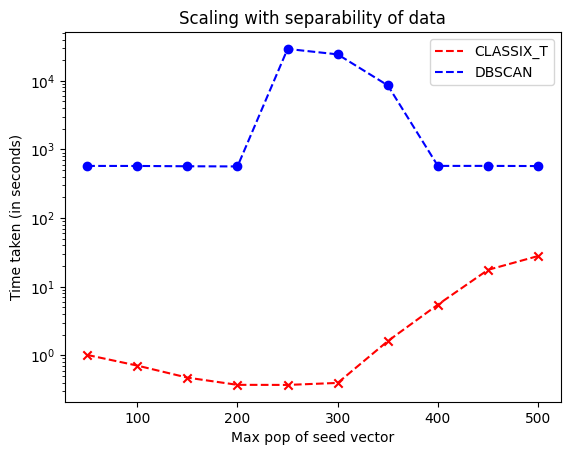

In [15]:
from matplotlib import pyplot as plt
plt.plot(np.arange(10)*50+50, clx_time, label="CLASSIX_T", linestyle='--', color='red')
# plt.plot(np.arange(10)*50+50, optics_time, label="OPTICS", linestyle='--', color='blue')
plt.plot(np.arange(10)*50+50, db_time, label="DBSCAN", linestyle='--', color='blue')
# plt.scatter(np.arange(10)*50+50, optics_time, color='blue', marker='o')
plt.scatter(np.arange(10)*50+50, db_time, color='blue', marker='o')
plt.scatter(np.arange(10)*50+50, clx_time, color='red', marker='x')
plt.xlabel("Max pop of seed vector")
plt.ylabel("Time taken (in seconds)")
plt.legend()
plt.yscale('log')
plt.title("Scaling with separability of data")
plt.savefig("separability_scaling_25k_1k.svg", format='svg', dpi=600)

In [10]:
time_dbscan = [31.507288217544556, 251.60820055007935, 565.7218034267426, 1009.0474061965942, 1580.219331741333, 2278.7760360240936, 3106.8421988487244, 4246.759449005127, 5395.957197189331, 6321.447096347809]
time_optics = [178.8456621170044, 710.1916806697845, 1583.2271282672882, 2818.0348076820374, 4391.019467115402, 6320.870121240616, 8812.178093671799, 11769.123373508453, 14688.89226269722, 17508.670217990875]
time_classix = [0.48612165451049805, 0.8780410289764404, 1.9289584159851074, 3.055576801300049, 5.159502029418945, 3.058633804321289, 7.453414678573608, 17.33303952217102, 21.7065851688385, 28.186944723129272]
npts = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]

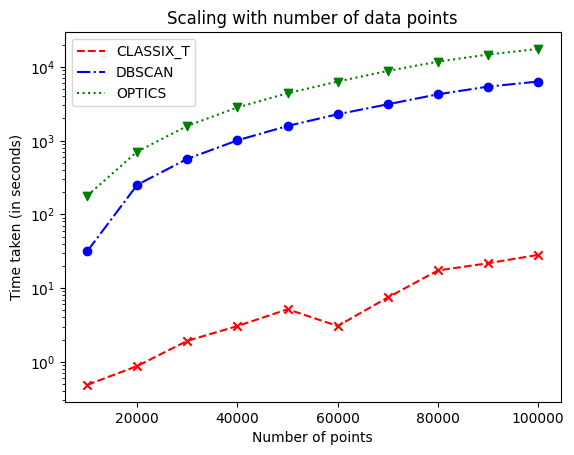

In [11]:
from matplotlib import pyplot as plt
db_points = np.array(list(zip(npts, time_dbscan)))
# optics_points = np.array(list(zip(npts, time_optics)))
# classix_points = np.array(list(zip(npts, time_classix)))
plt.plot(npts, time_classix, label="CLASSIX_T", linestyle='--', color='red')
plt.plot(npts, time_dbscan, label="DBSCAN", linestyle='-.', color='blue')
plt.plot(npts, time_optics, label="OPTICS", linestyle='dotted', color='green')
plt.scatter(npts, time_classix, color='red', marker='x')
plt.scatter(npts, time_dbscan, color='blue', marker='o')
plt.scatter(npts, time_optics, color='green', marker='v')
plt.xlabel("Number of points")
plt.ylabel("Time taken (in seconds)")
plt.legend()
plt.yscale('log')
plt.title("Scaling with number of data points")
plt.savefig("numpts_scaling.svg", format='svg', dpi=600)

Experiment 3: Dependence on number of clusters

We generate data keeping the dimension constant at d=1000. The total number of data points is constant at n=100000. The number of clusters is increased in steps of 10, starting from 10 upto 100, while only choosing values of num_clusters such that n is divisible by it. We observe and note the runtime of CLASSIX and compare it with scikit-learn DBSCAN with 'jaccard' metric. In the first experiment, we use clusters that are well separated by pop-counts.

In [ ]:
nClusters = [10, 20, 25, 40, 50, 80, 100]
n = 10000
# db_time = []
# classix_time = []
classix_time_2 = []
# optics_time = []
for i in nClusters:
    data, labels = generate_data(i, [100, 200], 1000, n//i, 0.3, 0)
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    tanimoto_radius = 0.4
    minPts = 5
    mergeScale = 1/np.sqrt(tanimoto_radius)

    # start = time.time()
    # db = DBSCAN(eps=0.4, min_samples=5, metric='jaccard' ).fit(data)
    # end = time.time()
    # print("DBSCAN took", end-start, "seconds")
    # db_time.append(end-start)
    # ari_score = ari(labels, db.labels_)
    # print("ARI score for DBSCAN:", ari_score)

    # start = time.time()
    # db = OPTICS(max_eps=0.4, min_cluster_size=5, metric='jaccard' ).fit(data)
    # end = time.time()
    # print("OPTICS took", end-start, "seconds")
    # optics_time.append(end-start)
    # ari_score = ari(labels, db.labels_)
    # print("ARI score for OPTICS:", ari_score)

    clx_t = CLASSIX_T(radius=tanimoto_radius, minPts=minPts, mergeScale=mergeScale)
    start = time.time()
    clx_t.fit(data)
    end = time.time()
    print("CLASSIX_T took", end-start, "seconds")
    classix_time_2.append(end-start)
    ari_score = ari(labels, clx_t.labels)
    print("ARI score for CLASSIX_T:", ari_score)

The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 123958.71it/s]


time for ips: 0.006601572036743164
time for search: 0.0018224716186523438
time for conversion: 0.00035071372985839844
time for loop: 0.06941652297973633
nr_dist: 58031


100%|██████████| 10/10 [00:00<00:00, 17476.27it/s]

  merging time: 0.0017032623291015625
 minPts Merging
  minPts merging time: 8.726119995117188e-05
Total time: 0.16336703300476074
CLASSIX_T took 0.16450214385986328 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 69923.13it/s]


time for ips: 0.008312225341796875
time for search: 0.0002624988555908203
time for conversion: 0.0010499954223632812
time for loop: 0.13104748725891113
nr_dist: 121312


100%|██████████| 20/20 [00:00<00:00, 18940.19it/s]


  merging time: 0.002231121063232422
 minPts Merging
  minPts merging time: 0.00013780593872070312
Total time: 0.21960783004760742
CLASSIX_T took 0.22078180313110352 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 55811.69it/s]


time for ips: 0.010242938995361328
time for search: 0.0003256797790527344
time for conversion: 0.0009436607360839844
time for loop: 0.1651463508605957
nr_dist: 153597


100%|██████████| 25/25 [00:00<00:00, 18545.74it/s]


  merging time: 0.002582073211669922
 minPts Merging
  minPts merging time: 0.00016379356384277344
Total time: 0.25731897354125977
CLASSIX_T took 0.2585470676422119 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 30178.08it/s]


time for ips: 0.022627592086791992
time for search: 0.0014233589172363281
time for conversion: 0.002248048782348633
time for loop: 0.3012692928314209
nr_dist: 292995


100%|██████████| 47/47 [00:00<00:00, 20650.77it/s]


  merging time: 0.0036118030548095703
 minPts Merging
  minPts merging time: 0.00024127960205078125
Total time: 0.4213120937347412
CLASSIX_T took 0.42227911949157715 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 29072.70it/s]


time for ips: 0.020700931549072266
time for search: 0.0024847984313964844
time for conversion: 0.001383066177368164
time for loop: 0.3159325122833252
nr_dist: 298084


100%|██████████| 50/50 [00:00<00:00, 23920.98it/s]


  merging time: 0.0035250186920166016
 minPts Merging
  minPts merging time: 0.00030112266540527344
Total time: 0.4250361919403076
CLASSIX_T took 0.42598700523376465 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 16556.84it/s]


time for ips: 0.037244319915771484
time for search: 0.004130125045776367
time for conversion: 0.003233671188354492
time for loop: 0.5546526908874512
nr_dist: 528348


100%|██████████| 83/83 [00:00<00:00, 25028.92it/s]


  merging time: 0.0048220157623291016
 minPts Merging
  minPts merging time: 0.0004520416259765625
Total time: 0.6878840923309326
CLASSIX_T took 0.6889910697937012 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 14616.44it/s]


time for ips: 0.041522979736328125
time for search: 0.0018112659454345703
time for conversion: 0.001413583755493164
time for loop: 0.6346256732940674
nr_dist: 611088


100%|██████████| 100/100 [00:00<00:00, 26308.12it/s]

  merging time: 0.005953073501586914
 minPts Merging
  minPts merging time: 0.0005900859832763672
Total time: 0.7657108306884766
CLASSIX_T took 0.7668049335479736 seconds
ARI score for CLASSIX_T: 1.0


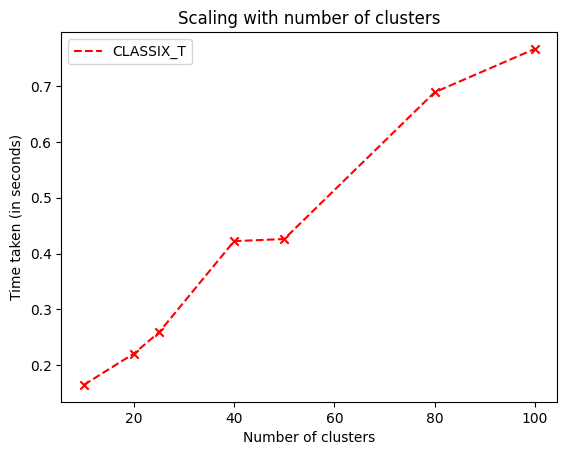

In [89]:
# time_classix_t = [0.17299199104309082, 0.26917576789855957, 0.31580376625061035, 0.43994998931884766, 0.4977238178253174, 0.5617668628692627, 0.7851078510284424]
# nClusters = [10, 20, 25, 33, 40, 50, 80]
# ari_classix_t = [1.0, 1.0]
from matplotlib import pyplot as plt
plt.plot(nClusters, classix_time_2, label="CLASSIX_T", linestyle='--', color='red')
plt.scatter(nClusters, classix_time_2, color='red', marker='x')
# plt.plot(nClusters, db_time, label="DBSCAN", linestyle='-.', color='blue')
# plt.scatter(nClusters, db_time, color='blue', marker='o')
# plt.plot(nClusters, optics_time, label="OPTICS", linestyle='dotted', color='green')
# plt.scatter(nClusters, optics_time, color='green', marker='v')
plt.xlabel("Number of clusters")
plt.ylabel("Time taken (in seconds)")
plt.legend()
plt.title("Scaling with number of clusters")
plt.savefig("numclusters_scaling.svg", format='svg', dpi=600)

Experiment 4: Dependence on data dimension

We generate data containing 10 clusters with 1000 points in each cluster. We vary the dimension of the data d from 500 to 5000 in increments of 500. We compare the results with scikit-learn DBSCAN with 'jaccard' metric.

In [24]:
clx_time = []
db_time = []
clx_aris = []
db_aris = []
for i in range(10):
    data, labels = generate_data(10, [100, 100], 500*(i+1), 1000, 0.3, 0)
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]

    tanimoto_radius = 0.4
    minPts = 5
    mergeScale = 1/np.sqrt(tanimoto_radius)

    start = time.time()
    db = DBSCAN(eps=0.4, min_samples=5, metric='jaccard' ).fit(data)
    end = time.time()
    print("DBSCAN took", end-start, "seconds")
    db_time.append(end-start)
    ari_score = ari(labels, db.labels_)
    db_aris.append(ari_score)
    print("ARI score for DBSCAN:", ari_score)

    clx_t = CLASSIX_T(radius=tanimoto_radius, minPts=minPts, mergeScale=mergeScale)
    start = time.time()
    clx_t.fit(data)
    end = time.time()
    print("CLASSIX_T took", end-start, "seconds")
    clx_time.append(end-start)
    ari_score = ari(labels, clx_t.labels)
    clx_aris.append(ari_score)
    print("ARI score for CLASSIX_T:", ari_score)

The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user


/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 23.891263961791992 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 924609.04it/s]


time for ips: 0.00729060173034668
time for search: 0.00024199485778808594
time for conversion: 0.0003254413604736328
time for loop: 0.0008976459503173828
nr_dist: 102584


100%|██████████| 26/26 [00:00<00:00, 21632.99it/s]

  merging time: 0.002403736114501953
 minPts Merging
  minPts merging time: 0.00011086463928222656
Total time: 0.05917811393737793
CLASSIX_T took 0.06018376350402832 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 45.89123725891113 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 1179500.56it/s]


time for ips: 0.004758358001708984
time for search: 0.0007066726684570312
time for conversion: 0.0002913475036621094
time for loop: 0.0006806850433349609
nr_dist: 91136


100%|██████████| 10/10 [00:00<00:00, 13962.40it/s]

  merging time: 0.0018610954284667969
 minPts Merging
  minPts merging time: 8.511543273925781e-05
Total time: 0.07635998725891113
CLASSIX_T took 0.07761621475219727 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 65.02277827262878 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 1332117.13it/s]


time for ips: 0.004174947738647461
time for search: 0.0002086162567138672
time for conversion: 0.0005199909210205078
time for loop: 0.0006167888641357422
nr_dist: 76172


100%|██████████| 10/10 [00:00<00:00, 20242.78it/s]

  merging time: 0.0015501976013183594
 minPts Merging
  minPts merging time: 8.606910705566406e-05
Total time: 0.0887610912322998
CLASSIX_T took 0.0902261734008789 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 85.70165514945984 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 1373065.77it/s]


time for ips: 0.004457235336303711
time for search: 0.000102996826171875
time for conversion: 0.0002143383026123047
time for loop: 0.0005960464477539062
nr_dist: 89879


100%|██████████| 10/10 [00:00<00:00, 17512.75it/s]

  merging time: 0.001767873764038086
 minPts Merging
  minPts merging time: 8.487701416015625e-05
Total time: 0.10520696640014648
CLASSIX_T took 0.10715007781982422 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 105.56424808502197 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 1160506.89it/s]


time for ips: 0.004967451095581055
time for search: 0.00011372566223144531
time for conversion: 0.0008454322814941406
time for loop: 0.0007393360137939453
nr_dist: 96430


100%|██████████| 10/10 [00:00<00:00, 17512.75it/s]

  merging time: 0.0016980171203613281
 minPts Merging
  minPts merging time: 9.083747863769531e-05
Total time: 0.12247014045715332
CLASSIX_T took 0.12440323829650879 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 128.1229329109192 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 1002295.03it/s]


time for ips: 0.006337404251098633
time for search: 0.0003590583801269531
time for conversion: 0.0004649162292480469
time for loop: 0.0007848739624023438
nr_dist: 98547


100%|██████████| 10/10 [00:00<00:00, 9736.08it/s]

  merging time: 0.002285003662109375
 minPts Merging
  minPts merging time: 0.00015616416931152344
Total time: 0.14475083351135254
CLASSIX_T took 0.14678001403808594 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 149.31435704231262 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 929897.79it/s]


time for ips: 0.007229328155517578
time for search: 0.00039887428283691406
time for conversion: 0.00021219253540039062
time for loop: 0.000843048095703125
nr_dist: 99701


100%|██████████| 10/10 [00:00<00:00, 9442.38it/s]

  merging time: 0.002543210983276367
 minPts Merging
  minPts merging time: 0.00016999244689941406
Total time: 0.16842317581176758
CLASSIX_T took 0.17064976692199707 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 170.35503888130188 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 1018529.38it/s]


time for ips: 0.006279945373535156
time for search: 0.00043654441833496094
time for conversion: 0.00024509429931640625
time for loop: 0.0008883476257324219
nr_dist: 90718


100%|██████████| 10/10 [00:00<00:00, 11481.81it/s]

  merging time: 0.0021021366119384766
 minPts Merging
  minPts merging time: 0.0001518726348876953
Total time: 0.17778921127319336
CLASSIX_T took 0.18025970458984375 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 189.96056199073792 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 919037.64it/s]


time for ips: 0.0066411495208740234
time for search: 0.00036263465881347656
time for conversion: 0.00024962425231933594
time for loop: 0.0014264583587646484
nr_dist: 99454


100%|██████████| 10/10 [00:00<00:00, 11905.49it/s]

  merging time: 0.0020508766174316406
 minPts Merging
  minPts merging time: 8.797645568847656e-05
Total time: 0.18843293190002441
CLASSIX_T took 0.1906590461730957 seconds
ARI score for CLASSIX_T: 1.0
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



/Users/user/anaconda3/envs/classix/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


DBSCAN took 209.1286211013794 seconds
ARI score for DBSCAN: 1.0

OWN AGGREGATION


100%|██████████| 10000/10000 [00:00<00:00, 931632.79it/s]


time for ips: 0.006820201873779297
time for search: 0.0008647441864013672
time for conversion: 0.00021648406982421875
time for loop: 0.0007894039154052734
nr_dist: 93785


100%|██████████| 10/10 [00:00<00:00, 11973.46it/s]

  merging time: 0.001961946487426758
 minPts Merging
  minPts merging time: 0.00010991096496582031
Total time: 0.20409202575683594
CLASSIX_T took 0.20650911331176758 seconds
ARI score for CLASSIX_T: 1.0


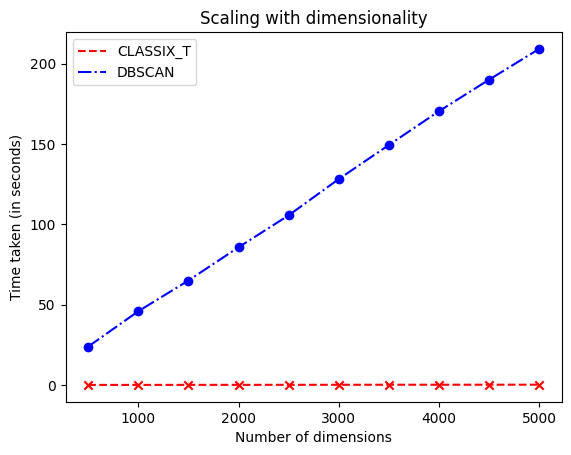

In [25]:
from matplotlib import pyplot as plt
plt.plot(np.arange(10)*500+500, clx_time, label="CLASSIX_T", linestyle='--', color='red')
plt.plot(np.arange(10)*500+500, db_time, label="DBSCAN", linestyle='-.', color='blue')
plt.scatter(np.arange(10)*500+500, clx_time, color='red', marker='x')
plt.scatter(np.arange(10)*500+500, db_time, color='blue', marker='o')
plt.xlabel("Number of dimensions")
plt.ylabel("Time taken (in seconds)")
plt.legend()
plt.title("Scaling with dimensionality")
plt.savefig("dimensionality_scaling.svg", format='svg', dpi=600)

In [4]:
# data = muf['data']
# labels = muf['labels'].flatten()
# data_min = muf2['data']
# labels_min = muf2['labels'].flatten()

Experiment 5: Sensitivity to parameters

We generate data containing 10 clusters with 10000 points in each cluster, keeping the dimension of the data constant d=1000. We vary the radius parameter of CLASSIX_T from 0.1 to 0.7 and observe the results.

In [25]:
# Scaling of Classix T in number of Data Points. 
"""
Constants:
Number of Clusters: 20
Dimension of Data: 1024
Flip Ratio: 4
Popcount: [50, 100] evenly spaced

We start with 100 data points in each cluster and increase the number of points in each cluster by a factor of 10.
We keep the number of clusters constant at 50 and the dimension of the data constant at 1024. The clusters a moderately separable in pop counts,
with the pop counts ranging from 50 to 100. The flip ratio is kept at 4.
Parameters:
Tanimoto Radius: 0.3
minPts: 40
scale: 1.4
"""

array([  0,   1,   2, ..., 498, 498, 497])

In [5]:
runtimes = []
for i in range(2, 6):
    data, labels = generate_data(20, [50, 100], 1024, (10**i), flip_ratio=4, seed=0)
    clx_t = CLASSIX_T(radius=0.3, minPts=40, mergeScale=1.4)
    start = time.time()
    clx_t.fit(data)
    end = time.time()
    runtimes.append(end-start)
    # print(f"Number of Data Points: {100*(10**i)} Time: {end-start}")

The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 2000/2000 [00:00<00:00, 649373.59it/s]


time for ips: 0.0009677410125732422
time for search: 6.270408630371094e-05
time for conversion: 7.557868957519531e-05
time for loop: 0.0014913082122802734
nr_dist: 16277


100%|██████████| 20/20 [00:00<00:00, 31453.35it/s]

  merging time: 0.0016629695892333984
 minPts Merging
  minPts merging time: 0.00014972686767578125
Total time: 0.01642322540283203
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



OWN AGGREGATION


100%|██████████| 20000/20000 [00:00<00:00, 1902394.38it/s]


time for ips: 0.005323171615600586
time for search: 0.000194549560546875
time for conversion: 0.0002841949462890625
time for loop: 0.0009338855743408203
nr_dist: 161968


100%|██████████| 20/20 [00:00<00:00, 9565.12it/s]

  merging time: 0.0036993026733398438
 minPts Merging
  minPts merging time: 0.00017714500427246094
Total time: 0.12446379661560059
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user



OWN AGGREGATION


100%|██████████| 200000/200000 [00:00<00:00, 1936330.10it/s]


time for ips: 0.05554056167602539
time for search: 0.002987384796142578
time for conversion: 0.0031511783599853516
time for loop: 0.0053746700286865234
nr_dist: 1618688


100%|██████████| 20/20 [00:00<00:00, 21210.13it/s]


  merging time: 0.0021431446075439453
 minPts Merging
  minPts merging time: 0.00013780593872070312
Total time: 1.3127868175506592
The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user


: 

In [7]:
data, labels = generate_data(10, [50, 400], 2000, 5000, 0.3, 0)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

tanimoto_radius = 0.2
minPts = 1000
mergeScale = 1/np.sqrt(tanimoto_radius)

clx_t = CLASSIX_T(radius=tanimoto_radius, minPts=minPts, mergeScale=mergeScale)
start = time.time()
clx_t.fit(data)
end = time.time()
print("CLASSIX_T took", end-start, "seconds")

The number of mean populations is not equal to the number of clusters. Trying to generate mean populations keeping in mind the minimum and maximum pop counts provided by the user

OWN AGGREGATION


100%|██████████| 50000/50000 [00:44<00:00, 1130.84it/s]


time for ips: 39.54012966156006
time for search: 0.9123303890228271
time for conversion: 0.8182709217071533
time for loop: 2.5935745239257812
nr_dist: 294256877


100%|██████████| 43028/43028 [01:23<00:00, 512.76it/s] 


  merging time: 84.72542691230774
 minPts Merging
  minPts merging time: 0.003662109375
Total time: 129.5756709575653
CLASSIX_T took 129.5931339263916 seconds


In [8]:
clx_t.labels

array([5, 0, 1, ..., 7, 9, 4])

In [9]:
len(np.unique(clx_t.labels))

10